## Denoising with Noise2Void

Notebook based on: https://careamics.github.io/0.1/applications/Noise2Void/Mouse_Nuclei/ 

Before you start executing code get GPU acces Runtime -> Change Runtime Type -> T4 GPU

Install necessary packages:

In [58]:
!pip install careamics

Import packages used in the notebook:

In [1]:
# Imports necessary to execute the code

import os
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
import numpy as np
from careamics import CAREamist
from careamics.config import create_n2v_configuration

Confirm access to GPU:

In [2]:
import torch
torch.cuda.is_available()

True

When you execute the cell below, a github repository will be cloned and test images will be available in your session. 

You can see available files by clicking the folder icon in the left side menu. 

Alternatively you can upload files directly from your drive to the session sotrage by using the upload button (in the Files tab).

In [ ]:
!git clone https://github.com/fjorka/OMIBS2025.git

## Load the dataset


In [ ]:
train_data = imread('./OMIBS_2025/sample_images/flywing.tif')
print(f'Image stack of shape: {train_data.shape}')

Image stack of shape: (50, 512, 512)


### Visualize data

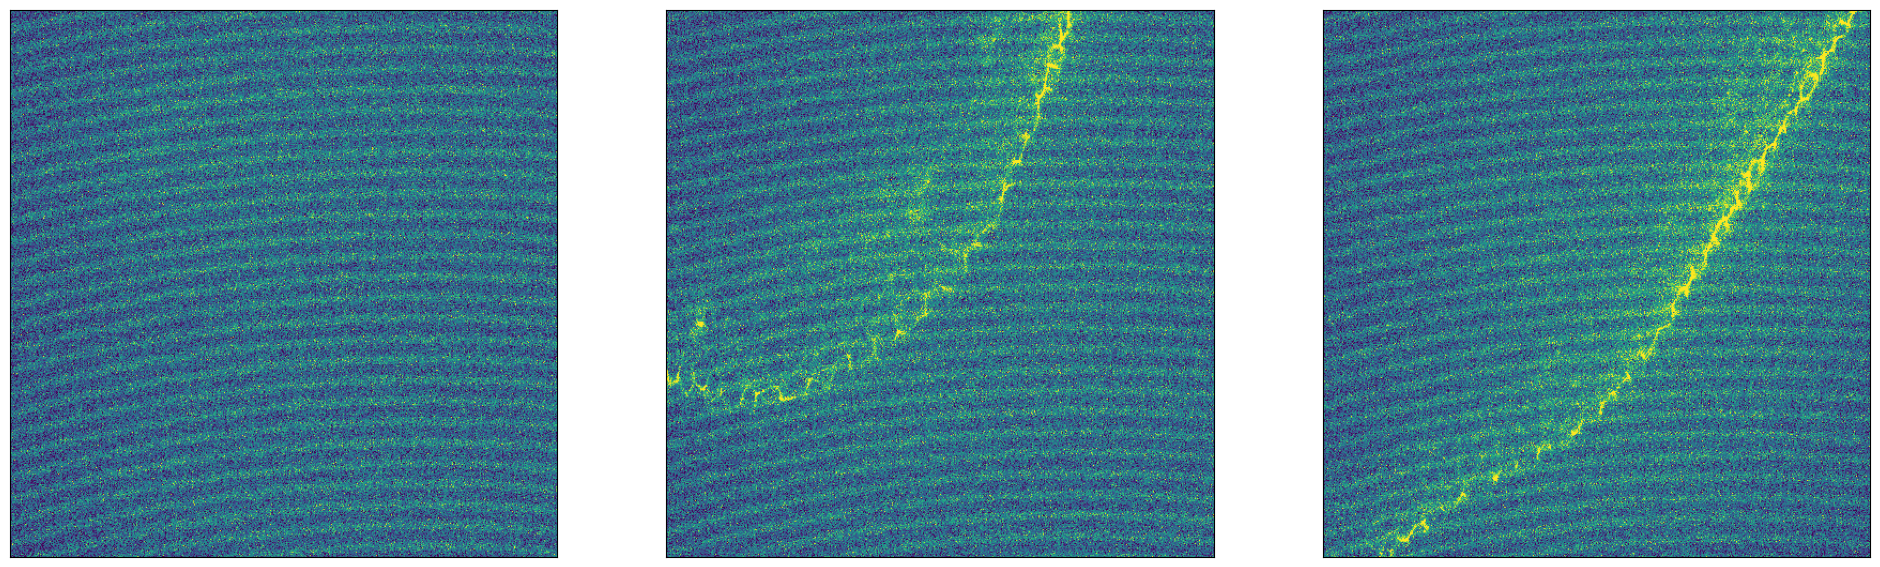

In [4]:
selected_indexes = [10,35,49] # change values to display different frames

fig, ax = plt.subplots(1, 3, figsize=(24, 24))
for i in range(3):
    ax[i].imshow(train_data[selected_indexes[i]], cmap="viridis")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the 
various parameters available in CAREamics. However, a straightforward way to create a 
configuration for a particular algorithm is to use one of the convenience functions.

In [9]:
config = create_n2v_configuration(
    experiment_name="flywing_n2v",
    data_type="array",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=16,
    num_epochs=1,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'n2v_config': {'masked_pixel_percentage': 0.2,
                                     'name': 'N2VManipulate',
                                     'remove_center': True,
                                     'roi_size': 11,
                                     'strategy': 'uniform',
                

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [10]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_data,
)

No working directory provided. Using current working directory: /home/kasia/omibs.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Computed dataset mean: [95.72826263], std: [50.59200119]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Predict with CAREamics

In [11]:
prediction = careamist.predict(source=train_data)
prediction = np.array([p.squeeze() for p in prediction])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

## Visualize the results

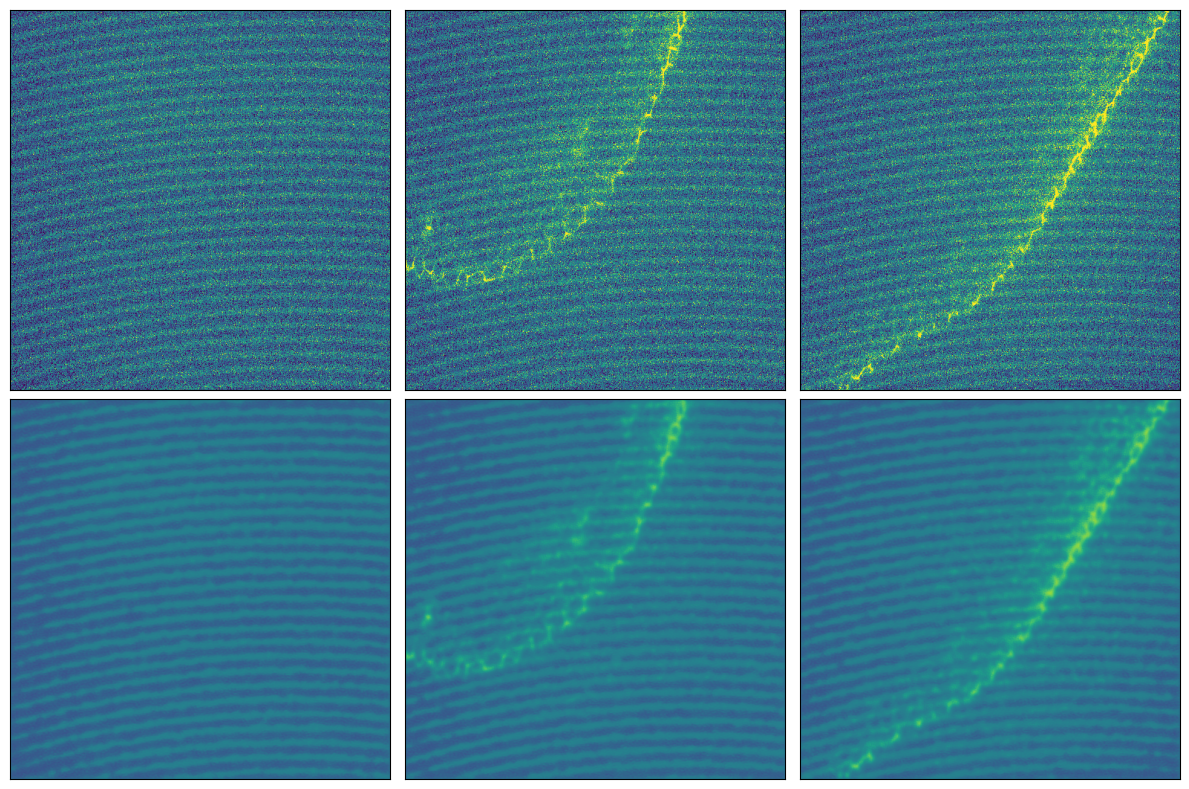

In [12]:
selected_indexes = [10,35,49] # change values to display different frames

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i in range(3):
    ax[0, i].imshow(train_data[selected_indexes[i]], cmap="viridis", vmin=0, vmax=255)
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])

    ax[1, i].imshow(prediction[selected_indexes[i]], cmap="viridis", vmin=0, vmax=255)
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

plt.tight_layout()
plt.show()

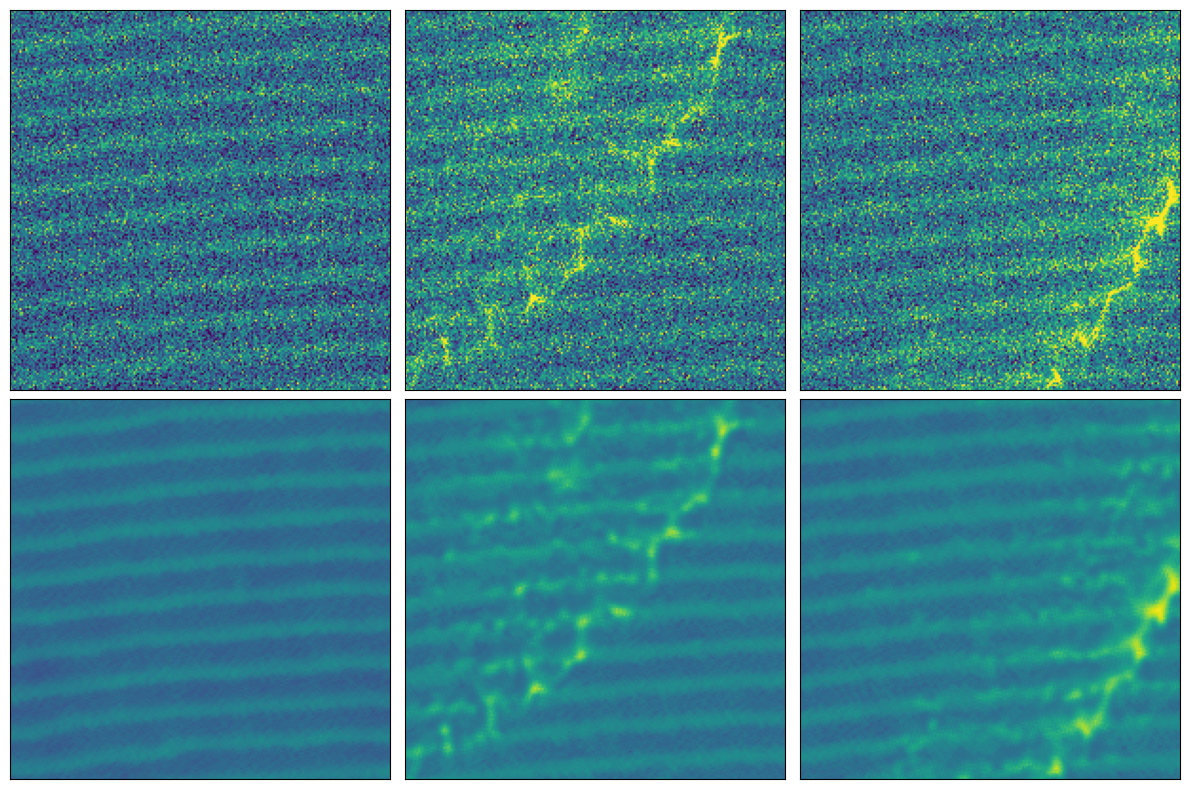

In [92]:
selected_indexes = [10,35,49] # change values to display different frames

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i in range(3):
    ax[0, i].imshow(train_data[selected_indexes[i]][150:350,150:350], cmap="viridis", vmin=0, vmax=255)
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])

    ax[1, i].imshow(prediction[selected_indexes[i]][150:350,150:350], cmap="viridis", vmin=0, vmax=255)
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

plt.tight_layout()
plt.show()


## Save the results

In [93]:
imwrite('sample_images/flywing_n2v.tif', prediction)